In [1]:
import os
#import sys
#import base64
#import io
import numpy as np
#import Pk_library as PKL
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

import utilities 
import flow_architecture
import training_data

torch.cuda.empty_cache()

IMPORT ERROR: /usr/local/lib/python3.8/dist-packages/quicklens/mpi.py. Could not load pbs or pypar. MPI will not be used.
IMPORT ERROR: /usr/local/lib/python3.8/dist-packages/quicklens/shts/__init__.py ({}). Try running 'python setup.py install' or 'python setup.py build_ext --inplace' from the quicklens directory.


In [2]:
if torch.cuda.is_available():
  torch_device = 'cuda'
  float_dtype = np.float32
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  torch.cuda.set_device(1)

In [3]:
save_dir = 'apr3_8_12_12'
if not os.path.exists(save_dir): os.makedirs(save_dir)

# training data

In [4]:
nx = 32
trainingdata = training_data.TrainingDataPersistentImages0_Om_s8()
padding_mode = 'zeros'

Om: [0.4107] s8: [0.6418]


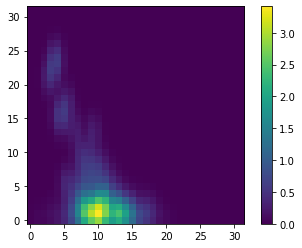

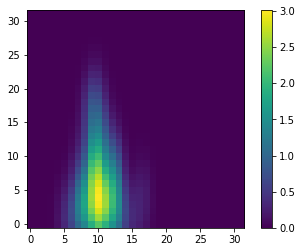

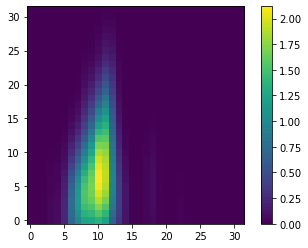

In [5]:
test_sample, Om, s8 = trainingdata.draw_samples_of_px(1)
print('Om:', Om, 's8:', s8)
plt.imshow(trainingdata.draw_samples_of_px(1)[0][0, 0], origin='lower')
plt.colorbar()
plt.show()
plt.imshow(trainingdata.draw_samples_of_px(1)[0][0, 1], origin='lower')
plt.colorbar()
plt.show()
plt.imshow(trainingdata.draw_samples_of_px(1)[0][0, 2], origin='lower')
plt.colorbar()
plt.show()

# defining the flow

In [6]:
lattice_shape = (nx, nx)
priormode = "whitenoise"

In [7]:
if priormode == "whitenoise":
    prior = flow_architecture.SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
if priormode == "correlated":
    rfourier_shape = (nx, int(nx/2+1), 2)
    prior = flow_architecture.CorrelatedNormal(
        torch.zeros(rfourier_shape), torch.ones(rfourier_shape), nx, dx, trainingdata.cl_theo, torch_device)

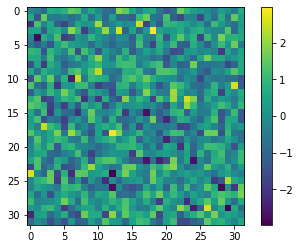

1.0013655


In [8]:
with torch.no_grad():
    nsamples = 100
    torch_z = prior.sample_n(nsamples)
    z = utilities.grab(torch_z)
    torch_logp = prior.log_prob(torch_z)
    logp = utilities.grab(torch_logp)

    plt.imshow(z[0])
    plt.colorbar()
    plt.show()

    print(np.std(z[0]))

In [9]:
n_layers = 8
hidden_sizes = [12, 12]
kernel_size = [3, 3, 3]
layers = flow_architecture.make_flow1_affine_layers(
    lattice_shape=lattice_shape, n_layers=n_layers, hidden_sizes=hidden_sizes,
    kernel_size=kernel_size, torch_device=torch_device, padding_mode=padding_mode)
model = {'layers': layers, 'prior': prior}

In [10]:
params = sum(p.numel() for p in model['layers'].parameters())
train_params = sum(p.numel() for p in model['layers'].parameters() if p.requires_grad)
print('Parameters:', params, '| Trainable parameters:', train_params)

Parameters: 93840 | Trainable parameters: 93840


# training

In [11]:
base_lr = 0.002
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

In [12]:
N_era = 1000
N_epoch = 1000
batch_size = 128

In [13]:
loss_list = []
val_list  = []

In [14]:
def train_step(model, optimizer, trainingdata):
    model['layers'].train()
    optimizer.zero_grad()
    
    x, Om, s8 = trainingdata.draw_samples_of_px(batch_size)
    x = torch.from_numpy(x).float().to(torch_device)
    noise = (prior.sample_n(batch_size)/20).unsqueeze(1).repeat(1, 3, 1, 1)
    x = x + noise
    Om = torch.from_numpy(Om).float().to(torch_device).unsqueeze(-1)
    s8 = torch.from_numpy(s8).float().to(torch_device).unsqueeze(-1)
    
    u, log_pu, log_J_Tinv = flow_architecture.apply_reverse_flow_to_sample(x, model['prior'], model['layers'], m1=Om, m2=s8)
    
    loss = -(log_pu + log_J_Tinv).mean()
    loss.backward()
    optimizer.step()
    loss_list.append(utilities.grab(loss))
    return loss

In [15]:
def val_step(model, trainingdata):
    model['layers'].eval();
    
    v, Om, s8 = trainingdata.draw_samples_of_pv(batch_size)
    v = torch.from_numpy(v).float().to(torch_device)
    noise = (prior.sample_n(batch_size)/20).unsqueeze(1).repeat(1, 3, 1, 1)
    v = v + noise
    Om = torch.from_numpy(Om).float().to(torch_device).unsqueeze(-1)
    s8 = torch.from_numpy(s8).float().to(torch_device).unsqueeze(-1)
    
    u, log_pu, log_J_Tinv = flow_architecture.apply_reverse_flow_to_sample(v, model['prior'], model['layers'], m1=Om, m2=s8)
    
    loss = -(log_pu + log_J_Tinv).mean()
    val_list.append(utilities.grab(loss))
    return loss

In [16]:
model['layers'].train();

In [17]:
if True:
    checkpoint = torch.load(save_dir+'/dict-1')
    loss_list = checkpoint['loss']
    val = checkpoint['val']
    model['layers'].load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
if True:
    for era in range(N_era):
        for epoch in range(N_epoch):
            loss = train_step(model, optimizer, trainingdata)
            val = val_step(model, trainingdata)
            
        scheduler.step(loss)
        
        print(era, '|', loss_list[-1], '|', val_list[-1], '|', optimizer.param_groups[0]['lr'])
        
        all_dict = {'model_state_dict': model['layers'].state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': loss_list,
                    'val': val_list}
        torch.save(all_dict, save_dir+'/dict-1')
        torch.save(all_dict, save_dir+'/dict-1-backup')

0 | -4516.9443 | -4519.201 | 0.002
1 | -4516.944 | -4519.4766 | 0.002
2 | -4529.6143 | -4511.4155 | 0.002
3 | -4517.0303 | -4528.004 | 0.002
4 | -4518.779 | -4531.078 | 0.002
5 | -4521.5293 | -4510.7363 | 0.002
6 | -4512.2627 | -4516.783 | 0.002
7 | -4514.8457 | -4524.587 | 0.002
8 | -4525.999 | -4532.6904 | 0.002


In [19]:
model['layers'].eval();

ValueError: x and y must have same first dimension, but have shapes (30234,) and (12234,)

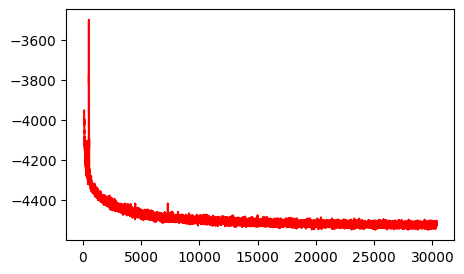

In [23]:
mpl.rcParams.update(mpl.rcParamsDefault)

idmin = 100
idmax = len(loss_list)

fig=plt.figure(figsize=(5, 3))
plt.plot(np.arange(idmin, idmax, 1), loss_list[idmin:idmax], color='red', label='Training')
plt.plot(np.arange(idmin, idmax, 1),  val_list[idmin:idmax], color='black', label='Validation')
plt.legend(loc=1, frameon=False)
#plt.ylim(-5000, 5000)
#plt.xscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')

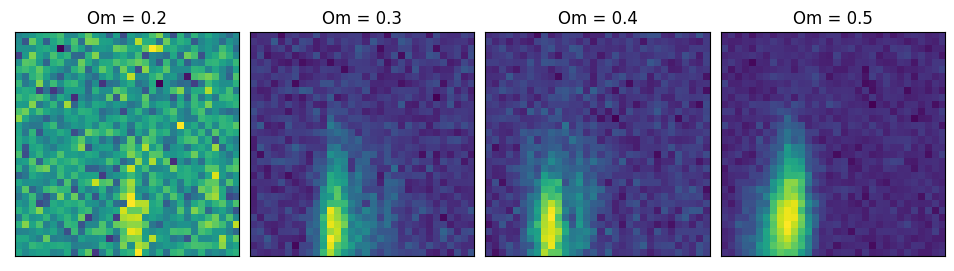

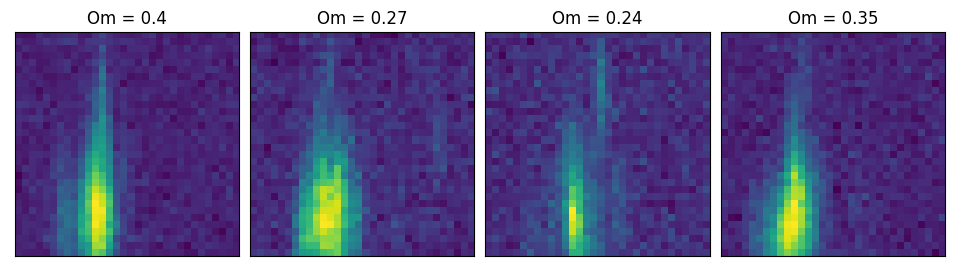

In [24]:
vmin = 0

with torch.no_grad():
    m1 = torch.tensor((0.2, 0.3, 0.4, 0.5)).to(torch_device).unsqueeze(-1)
    m2 = torch.tensor((0.5, 0.7, 0.9, 1.1)).to(torch_device).unsqueeze(-1)
    u, log_pu, z_torch, log_pz = flow_architecture.apply_flow_to_prior(prior, layers, batch_size=4, m1=m1, m2=m2)
    z = utilities.grab(z_torch)

    figure, axes = plt.subplots(1, 4, figsize=(12, 3))
    for col in range(4):
        pcm = axes[col].imshow(z[col, 2], origin='lower')
        axes[col].axes.get_xaxis().set_ticks([])
        axes[col].axes.get_yaxis().set_ticks([])
        axes[col].set_title('Om = '+str(np.round(utilities.grab(m1[col][0]), 2)))
    
    plt.subplots_adjust(wspace=0.05)
    #figure.colorbar(pcm, ax=axes[:], shrink=0.57)
    plt.show()

    v, Om, s8 = trainingdata.draw_samples_of_px(4)
    noise = utilities.grab((prior.sample_n(4)/20).unsqueeze(1).repeat(1, 3, 1, 1))
    v = v + noise
    figure, axes = plt.subplots(1, 4, figsize=(12, 3))
    for col in range(4):
        pcm = axes[col].imshow(v[col, 2], origin='lower')
        axes[col].axes.get_xaxis().set_ticks([])
        axes[col].axes.get_yaxis().set_ticks([])
        axes[col].set_title('Om = '+str(round(Om[col], 2)))
        
    plt.subplots_adjust(wspace=0.05)
    #figure.colorbar(pcm, ax=axes[:], shrink=0.57)
    plt.show()

In [25]:
def calc_p_and_plot(n_samples, save_name='result.pdf'):
    test_sample, Om_true, s8_true = trainingdata.draw_samples_of_pt(1)
    test_sample = torch.from_numpy(test_sample).float().to(torch_device)
    test_sample = test_sample + prior.sample_n(1)/20

    log_p_list = torch.zeros((n_samples, n_samples))
    i = 0
    j = 0
    with torch.no_grad():
        for Om in np.linspace(0.2, 0.5, n_samples):
            j = 0
            for s8 in np.linspace(0.5, 1.1, n_samples):
                Om = torch.tensor(Om).float().to(torch_device)
                s8 = torch.tensor(s8).float().to(torch_device)
                u, log_pu, log_J_Tinv = flow_architecture.apply_reverse_flow_to_sample(test_sample, model['prior'], model['layers'], m1=Om, m2=s8)
                log_p_list[i, j] = log_pu + log_J_Tinv
                j += 1
            i += 1
            
    plt.imshow(np.exp(utilities.grab(log_p_list)-4550), origin='lower')
    plt.gca().set_xticks(np.linspace(0, n_samples-1, 5))
    plt.gca().set_yticks(np.linspace(0, n_samples-1, 5))
    plt.gca().set_xticklabels(np.round(np.linspace(0.5, 1.1, 5), 2))
    plt.gca().set_yticklabels(np.round(np.linspace(0.2, 0.5, 5), 2))
    plt.ylabel('$\Omega_\mathrm{M}$')
    plt.xlabel('$\sigma_8$')
    plt.scatter((s8_true[0]-0.5)*n_samples/0.6, (Om_true[0]-0.2)*n_samples/0.3, s=50, c='red', marker='o')
    plt.title('Omega M true: '+str(np.round(Om_true[0], 2))+' | sigma 8 true: '+str(np.round(s8_true[0], 2)))
    plt.savefig(save_name)

<ipython-input-25-920793a9e85f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Om = torch.tensor(Om).float().to(torch_device)


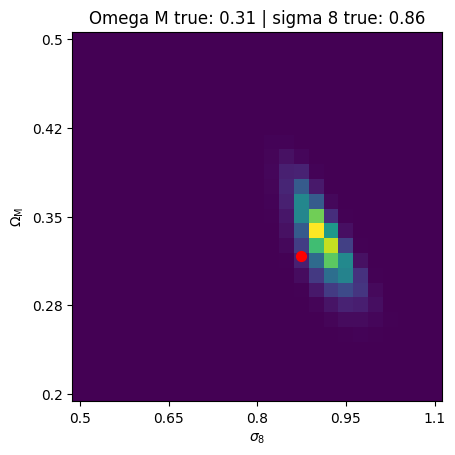

In [26]:
calc_p_and_plot(25, 'result_0.pdf')

<ipython-input-25-920793a9e85f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Om = torch.tensor(Om).float().to(torch_device)


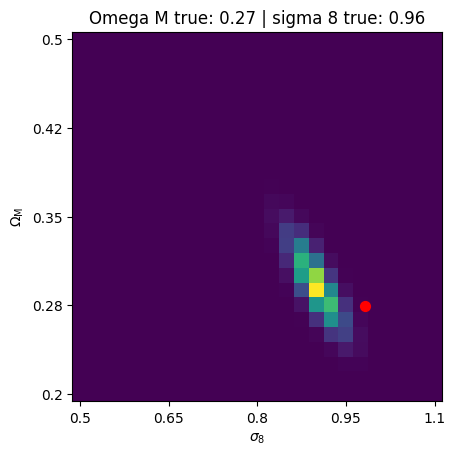

In [27]:
calc_p_and_plot(25, 'result_1.pdf')

In [ ]:
calc_p_and_plot(100, 'result_2.pdf')

In [ ]:
calc_p_and_plot(100, 'result_3.pdf')

In [ ]:
calc_p_and_plot(100, 'result_4.pdf')

In [ ]:
calc_p_and_plot(100, 'result_5.pdf')

In [ ]:
calc_p_and_plot(100, 'result_6.pdf')

In [ ]:
calc_p_and_plot(100, 'result_7.pdf')